# 4-1. 프로젝트: 뉴스기사 요약해보기
---

## 목차
---
### Step 1. 데이터 수집하기
### Step 2. 데이터 전처리(추상적 요약)
### Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
### Step 5. Summa을 이용해서 추출적 요약해보기


##  Step 1. 데이터 수집하기

- 라이브러리 임포트

In [1]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


- 데이터 수집

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

- 데이터 확인

In [3]:
data.shape

(98401, 2)

In [4]:
data.sample(10)

,headlines,text
6494,Congress won more number of seats while BJP go...,While Congress emerged as the single largest p...
70152,14 live bombs recovered in West Bengal a day a...,The police on Thursday recovered 14 live bombs...
45394,PSL players approached by bookies via social m...,The Pakistan Cricket Board (PCB) has revealed ...
5743,Man Utd fire JosÃÂ© Mourinho after worst ever...,Manchester United have sacked manager JosÃÂ© ...
97647,Amazon Founder Jeff Bezos pilots a 13-foot-tal...,"Jeff Bezos, the Founder and CEO of Amazon, pil..."
65839,Pained by communal angle given to firecracker ...,The Supreme Court on Friday refused to modify ...
38935,Deepika rejects xXx 4 offer because of her mar...,"As per reports, Deepika Padukone has rejected ..."
75526,People in Telangana town asked to sing nationa...,Police in Telangana's Jammikunta town have rep...
60924,Security forces told to eliminate those being ...,Following a review of Jammu and Kashmir's secu...
95467,Use video conferencing instead of summons: Mod...,PM Narendra Modi on Sunday said the courts cou...


In [5]:
print("headlines의 첫 번째 데이터 길이 : {}".format(len(data['headlines'][0])))
print("text의 첫 번째 데이터 길이 : {}".format(len(data['text'][0])))

headlines의 첫 번째 데이터 길이 : 65
text의 첫 번째 데이터 길이 : 375


- ✨headlines이 짧은 걸 확인할 수 있어 "Summary"에 해당한 부분이라고 알 수 있다.

### Step 2. 데이터 전처리(추상적 요약)

### 1) 중복 및 결측치 제거

In [6]:
print('text 열에서 중복을 배제한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 샘플의 수 : 98280


- Text를 기준으로 중복제거

In [7]:
data.drop_duplicates(subset=['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


- 결측치 확인

In [8]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


- 결측치는 따로 없으므로 dropna은 진행하지 않습니다.

In [9]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 2) 텍스트 정규화와 불용어 제거

- 정규화 데이터

<center>[정규화 사전 출처](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)</center>

In [10]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


- 불용어 데이터

In [11]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
print(len(stopwords.words('english')))
print("-"*4)
print(stopwords.words('english'))

179
----
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


- 데이터 전처리 함수

In [12]:
import re
from bs4 import BeautifulSoup

# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거  ## .find_all
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [13]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


- 보다시피 전처리된 모습을 확인할 수 있다.

In [14]:
clean_text = data['text'].apply(lambda x:preprocess_sentence(x))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  0    saurav kant alumnus upgrad iiit pg program mac...
1    kunal shah credit card bill payment platform c...
2    new zealand defeated india wickets fourth odi ...
3    aegon life iterm insurance plan customers enjo...
4    speaking sexual harassment allegations rajkuma...
Name: text, dtype: object


In [15]:
clean_headlines = data['headlines'].apply(lambda x:preprocess_sentence(x, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  0    upgrad learner switches to career in ml al wit...
1    delhi techie wins free food from swiggy for on...
2    new zealand end rohit sharma led india match w...
3    aegon life iterm insurance plan helps customer...
4    have known hirani for yrs what if metoo claims...
Name: headlines, dtype: object


In [17]:
import numpy as np

data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [18]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

- 결측치가 없으니 dropna은 따로 진행하지 않겠다.

In [19]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 3) 훈련데이터와 테스트데이터 나누기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


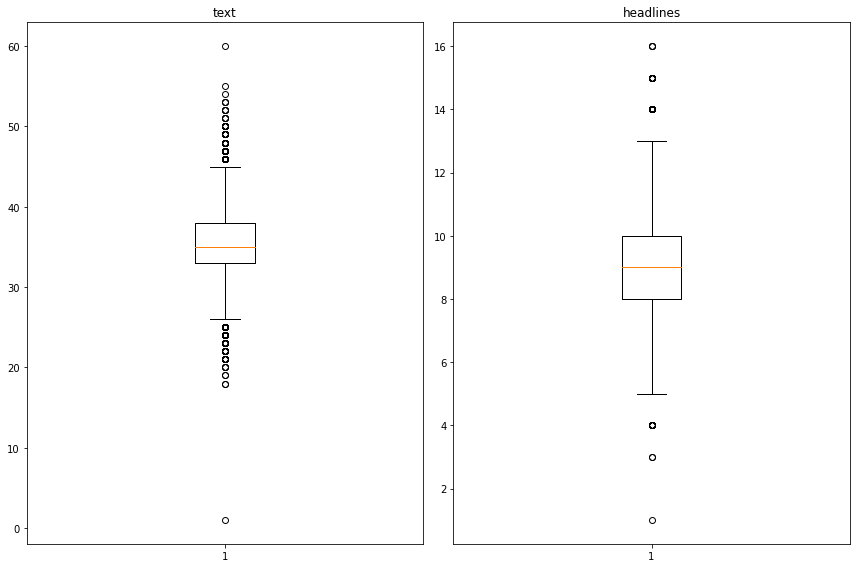

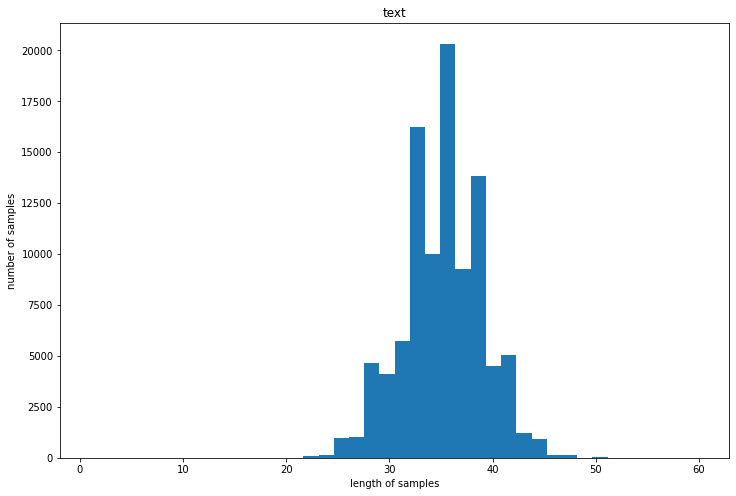

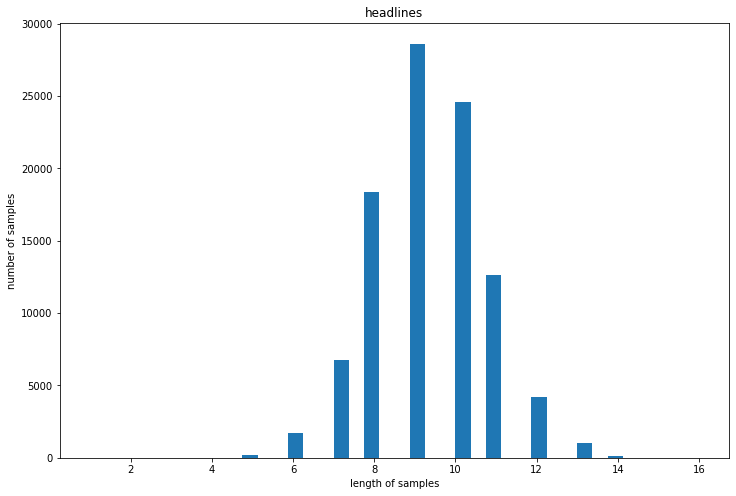

In [20]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.figure(figsize=(12, 8))
plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- boxplot을 확인해보면
    - Q3 + 1.5 x IQR 쯤 이상의 값
    - Q1 - 1.5 x IQR 이하의 값
- 은 이상치로 판단하는 게 좋을 듯 하다.

In [21]:
text_count_Q1 = pd.Series(text_len).quantile(0.25) # 사분위수 Q1 추출
text_count_Q3 = pd.Series(text_len).quantile(0.75) # 사분위수 Q3 추출
text_count_IQR = text_count_Q3 - text_count_Q1 # IQR 구함

text_max_len = int(text_count_Q3 + text_count_IQR*1.5) # upperline
text_min_len = int(text_count_Q1 - text_count_IQR*1.5) # underline

print('%s의 upperline 값은 %s'%('text', text_max_len))
print('%s의 underline 값은 %s'%('text', text_min_len))

text의 upperline 값은 45
text의 underline 값은 25


In [22]:
headlines_count_Q1 = pd.Series(headlines_len).quantile(0.25) # 사분위수 Q1 추출
headlines_count_Q3 = pd.Series(headlines_len).quantile(0.75) # 사분위수 Q3 추출
headlines_count_IQR = headlines_count_Q3 - headlines_count_Q1 # IQR 구함

headlines_max_len = int(headlines_count_Q3 + headlines_count_IQR*1.5) # upperline
headlines_min_len = int(headlines_count_Q1 - headlines_count_IQR*1.5) # underline

print('%s의 upperline 값은 %s'%('headlines', headlines_max_len))
print('%s의 underline 값은 %s'%('headlines', headlines_min_len))

headlines의 upperline 값은 13
headlines의 underline 값은 5


In [23]:
def threshold_len(nested_list, max_len, min_len=0):
  cnt = 0
  for s in nested_list:
    if (len(s.split()) <= max_len) and (len(s.split()) >= min_len) :
        cnt = cnt + 1
  print('전체 샘플 중 %s이하 및 %s이상인 샘플의 비율: %s'%(max_len, min_len, (cnt / len(nested_list))))

- 원본 데이터 백업

In [24]:
data2 = data.copy()

In [25]:
threshold_len(data['text'], text_max_len, text_min_len)
threshold_len(data['headlines'], headlines_max_len, headlines_min_len)

전체 샘플 중 45이하 및 25이상인 샘플의 비율: 0.994408296055307
전체 샘플 중 13이하 및 5이상인 샘플의 비율: 0.9979971533143555


- 거의 문장을 보존한 채 이상치만 제거가 가능한 것으로 보인다.

In [26]:
data['text'] = data['text'].apply(lambda x:x if (len(x.split()) <= text_max_len) and (len(x.split()) >= text_min_len) else np.nan)
data['headlines'] = data['headlines'].apply(lambda x:x if (len(x.split()) <= headlines_max_len) and (len(x.split()) >= headlines_min_len) else np.nan)
data.dropna(axis=0, inplace=True)

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 97614


In [27]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [55]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

- 순서를 섞기 위해 데이터 개수만큼 배열 생성

In [56]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[22901 67426 36313 ... 37633 46760 86458]


In [57]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

- 20%만큼 테스트 데이터 분류

In [58]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19522


In [59]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78092
훈련 레이블의 개수 : 78092
테스트 데이터의 개수 : 19522
테스트 레이블의 개수 : 19522


- 토큰화

In [60]:
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [61]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [62]:
threshold = 10
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69331
등장 빈도가 9번 이하인 희귀 단어의 수: 50975
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 18356
단어 집합에서 희귀 단어의 비율: 73.52410898443698
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.575352314427055


In [63]:
src_vocab = total_cnt - rare_cnt
src_tokenizer = Tokenizer(num_words=src_vocab) # 희귀 단어를 제외시킬 경우의 단어 집합으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [64]:
len(src_tokenizer.word_index)

69331

In [65]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[10182, 2, 907, 869, 1022, 269, 1588, 652, 106, 4447, 6228, 10183, 759, 642, 2208, 7990, 2417, 117, 427, 10182, 269, 106, 6, 116, 10183, 1946, 7990, 5357, 642, 7990, 6, 17, 4554, 1462, 1864, 3426, 10183, 263, 849], [420, 36, 87, 7733, 1339, 69, 1, 36, 233, 5031, 609, 37, 9, 16658, 1200, 325, 30, 23, 1, 11156, 1589, 17, 562, 1200, 2104, 29, 131, 5358], [434, 228, 3609, 752, 15320, 67, 2137, 3022, 11, 134, 469, 585, 18, 2636, 19, 293, 2137, 620, 226, 620, 9083, 21, 620, 55, 2, 9083, 3022, 571, 773]]


- encoder_input 데이터를 학습시킬 형태로 변형

In [66]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [67]:
threshold = 9
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30007
등장 빈도가 8번 이하인 희귀 단어의 수: 21838
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8169
단어 집합에서 희귀 단어의 비율: 72.77635218449029
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.563419718134586


In [68]:
tar_vocab = total_cnt - rare_cnt
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 7180, 278, 415, 1746, 357, 5, 842, 3222], [1, 31, 358, 97, 174, 2913, 111, 4103, 4370, 1823], [1, 1434, 334, 3, 384, 2914, 4, 328, 1891, 1229, 219], [1, 7612, 2039, 7, 2972, 78, 156, 3768], [1, 3880, 514, 5, 953, 7]]
target
decoder  [[7180, 278, 415, 1746, 357, 5, 842, 3222, 2], [31, 358, 97, 174, 2913, 111, 4103, 4370, 1823, 2], [1434, 334, 3, 384, 2914, 4, 328, 1891, 1229, 219, 2], [7612, 2039, 7, 2972, 78, 156, 3768, 2], [3880, 514, 5, 953, 7, 2]]


In [70]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78092
훈련 레이블의 개수 : 78092
테스트 데이터의 개수 : 19522
테스트 레이블의 개수 : 19522


- padding으로 sentence의 크기를 맞춰줌

In [71]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

### Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

- 모델 설계하기(인코더 인풋)

In [72]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [73]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [74]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2349568     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [75]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2349568     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

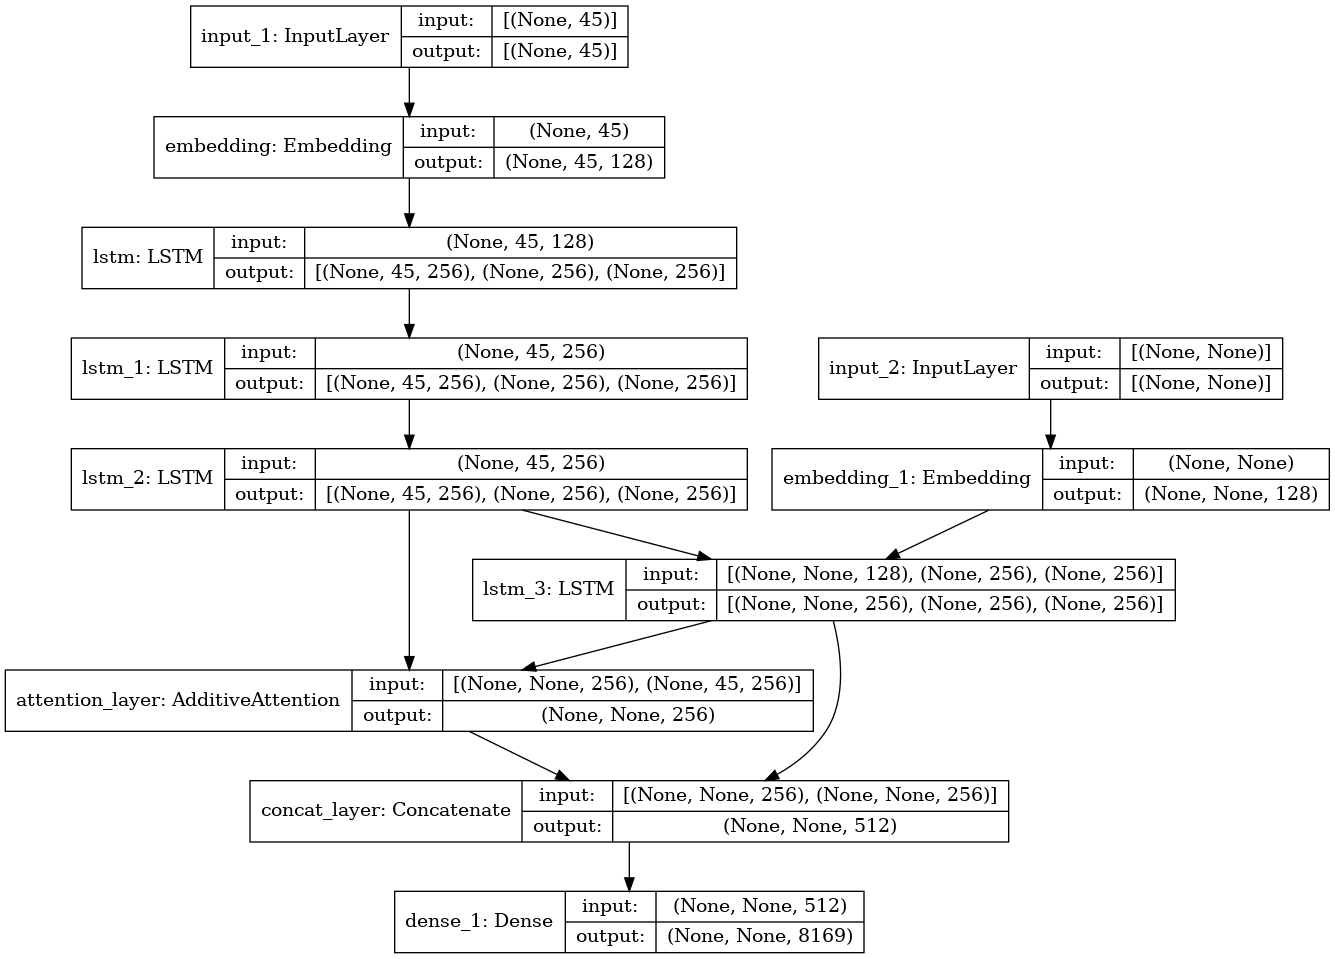

In [76]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [77]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
306/306 [==============================] - 133s 409ms/step - loss: 5.0938 - val_loss: 4.7433
Epoch 2/50
306/306 [==============================] - 125s 409ms/step - loss: 4.5213 - val_loss: 4.4001
Epoch 3/50
306/306 [==============================] - 125s 407ms/step - loss: 4.2148 - val_loss: 4.1461
Epoch 4/50
306/306 [==============================] - 123s 403ms/step - loss: 3.9793 - val_loss: 3.9643
Epoch 5/50
306/306 [==============================] - 123s 403ms/step - loss: 3.7927 - val_loss: 3.8589
Epoch 6/50
306/306 [==============================] - 123s 402ms/step - loss: 3.6353 - val_loss: 3.7233
Epoch 7/50
306/306 [==============================] - 122s 400ms/step - loss: 3.5000 - val_loss: 3.6364
Epoch 8/50
306/306 [==============================] - 123s 404ms/step - loss: 3.3842 - val_loss: 3.5704
Epoch 9/50
306/306 [==============================] - 123s 401ms/step - loss: 3.2840 - val_loss: 3.5091
Epoch 10/50
306/306 [==============================] - 123s 402m

- 에폭스 29회에서 early stopping으로 조기 종료된 모습

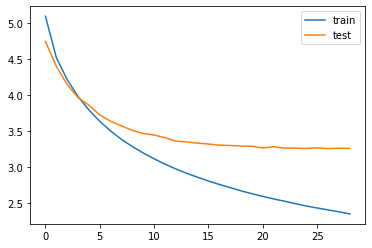

In [79]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [80]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [81]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

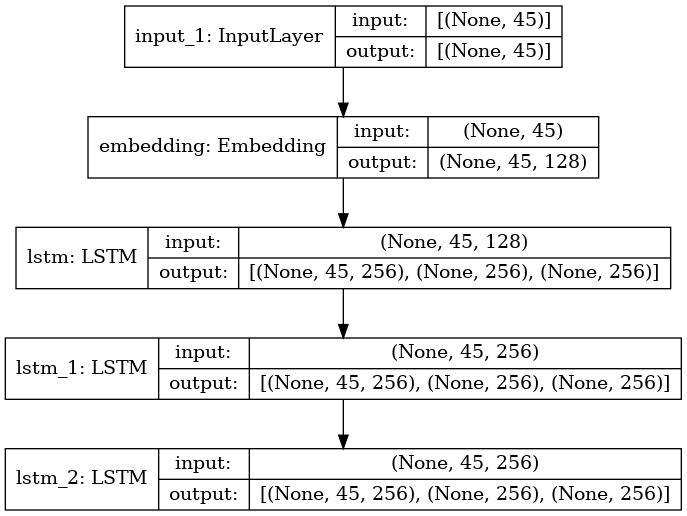

In [82]:
plot_model(encoder_model, to_file='encoder_model_plot.png', show_shapes=True, show_layer_names=True)

In [83]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

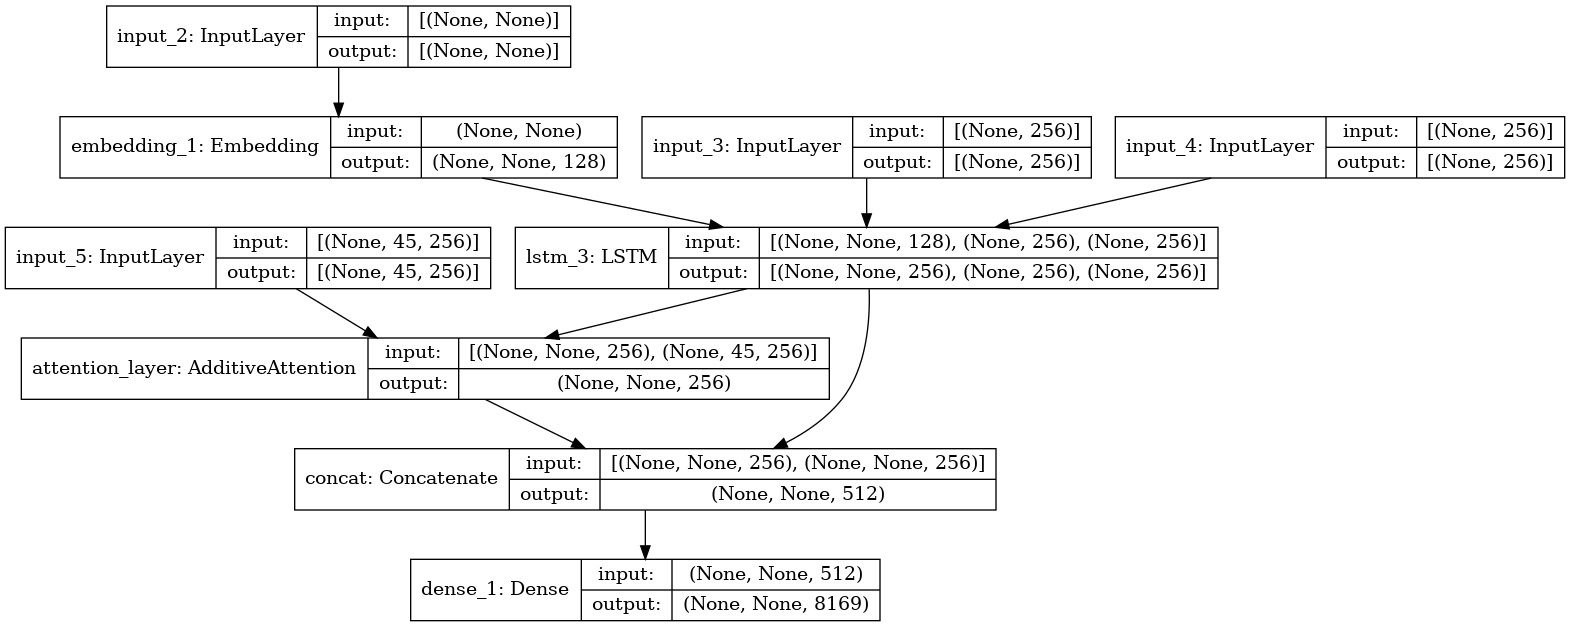

In [84]:
plot_model(decoder_model, to_file='decoder_model_plot.png', show_shapes=True, show_layer_names=True)

In [85]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [86]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + tar_index_to_word[i]+' '
    return temp[9:]

- Bleu, Rouge 스코어 구하기

In [87]:
pip install rouge-score

Note: you may need to restart the kernel to use updated packages.


In [88]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer

def calculate_bleu_score(reference, candidate):
    smooth = SmoothingFunction().method1  # BLEU smoothing function
    return corpus_bleu([[reference]], [candidate], smoothing_function=smooth)

def calculate_rouge_score(reference, candidate):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, candidate)
    return scores

In [92]:
for i in range(0, 30):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    # BLEU 계산
    bleu_score = calculate_bleu_score(seq2summary(decoder_input_test[i]), decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print(f"BLEU Score: {bleu_score:.4f}")
    # ROUGE 점수 계산
    rouge_score = calculate_rouge_score(seq2summary(decoder_input_test[i]), decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print(f"ROUGE-1 Score: {rouge_score['rouge1'].fmeasure:.4f}")
    print(f"ROUGE-2 Score: {rouge_score['rouge2'].fmeasure:.4f}")
    print(f"ROUGE-L Score: {rouge_score['rougeL'].fmeasure:.4f}")
    
    print("\n")

원문 : confederation india traders said walmart flipkart deal benefit venture investors country also said clear attempt walmart dominate retail trade india commerce uneven level playing field retail traders cait added 
실제 요약 : flipkart walmart deal will not benefit india traders body 
예측 요약 :  flipkart deal deal will not deal with walmart deal walmart
BLEU Score: 0.5627
ROUGE-1 Score: 0.5263
ROUGE-2 Score: 0.3529
ROUGE-L Score: 0.4211


원문 : india saw hottest winter recorded history temperatures reaching according centre science environment india warmest year ever hottest years since last years us exiting paris agreement controlling temperature tougher task said 
실제 요약 : india witnessed its winter ever in 
예측 요약 :  india to host th ever in yrs of april
BLEU Score: 0.3766
ROUGE-1 Score: 0.4000
ROUGE-2 Score: 0.1538
ROUGE-L Score: 0.4000


원문 : karnataka state tourism department displayed draft logo brand bengaluru love bengaluru tank invited responses visitors sunday logo chosen among ent

예측 요약 :  rbi to make account of old notes to rbi
BLEU Score: 0.2039
ROUGE-1 Score: 0.1111
ROUGE-2 Score: 0.0000
ROUGE-L Score: 0.1111


원문 : delhi witnessing polling civic body today bjp slammed chief minister arvind kejriwal electronic voting machines tampering saying fault evms kejriwal leadership bjp leader sambit patra said kejriwal language shows frustrated went goa punjab become cm nowhere 
실제 요약 : fault not with evms but with kejriwal bjp 
예측 요약 :  evms will be sisodia on evms kejriwal
BLEU Score: 0.3756
ROUGE-1 Score: 0.2667
ROUGE-2 Score: 0.0000
ROUGE-L Score: 0.2667


원문 : ipl official website shared video kkr captain dinesh karthik reading mean tweets tweets included dinesh karthik captain even near gautam gambhir captain kkr sorry true dinesh karthik vinay kumar standing together today would think twice slap first 
실제 요약 : change name to bose dinesh karthik reads mean tweets 
예측 요약 :  karthik calls karthik karthik to karthik
BLEU Score: 0.2259
ROUGE-1 Score: 0.2667
ROUGE-2 

### Step 5. Summa을 이용해서 추출적 요약해보기

- 패키지 Summa

In [93]:
import requests
from summa.summarizer import summarize

In [94]:
example_text = "In the heart of the bustling city, where skyscrapers touch the sky and neon lights paint the streets in vibrant hues, a sense of constant motion permeates the air. People, with dreams as diverse as the colors around them, weave through the urban tapestry, each step telling a unique story. Amidst the rhythmic symphony of car horns and distant chatter, the city becomes a canvas where ambitions flourish and destinies entwine, creating a pulsating energy that defines its character."
summarize(example_text, words=10)

''

- words 수가 문장에 따라 작으면 일일히 정해줘야만, 모든 문장에서 대해서 출력됨(위 예시처럼 words수가 작을 때 출력되지 않음)

In [95]:
def recall_summarize(summarize, sentence, words):
    return_sentence = summarize(sentence, words=words)
    if len(return_sentence) == 0:
        words += 1
        return recall_summarize(summarize, sentence, words)
    else:
        return return_sentence

- 이를 해결하고자 재귀호출함수 정의 후 사용(미출력 시, words 숫자 증가 후 다시 함수 리턴)

In [96]:
data3 = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [97]:
for i in range(0, 10):
    print("원문 :", data3['text'][i])
    print("실제 요약 :", data3['headlines'][i])
    print("추출적 요약 :", recall_summarize(summarize, data3['text'][i], 5))
    
    bleu_score = calculate_bleu_score(data3['headlines'][i], recall_summarize(summarize, data3['text'][i], 5))
    print(f"BLEU Score: {bleu_score:.4f}")
    # ROUGE 점수 계산
    rouge_score = calculate_rouge_score(data3['headlines'][i], recall_summarize(summarize, data3['text'][i], 5))
    print(f"ROUGE-1 Score: {rouge_score['rouge1'].fmeasure:.4f}")
    print(f"ROUGE-2 Score: {rouge_score['rouge2'].fmeasure:.4f}")
    print(f"ROUGE-L Score: {rouge_score['rougeL'].fmeasure:.4f}")
    
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
추출적 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.
BLEU Score: 0.2805
ROUGE-1 Score: 0.1818
ROUGE-2 Score: 0.0000
ROUGE-L Score: 0.1818


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food 

### 회고

#### Keep
긴것뿐만이 아니라 짧은 것도 제거하는 것은 잘한 것 같다. 그렇지만 꽤나 많이 잘랐음에도 99%로 이상치로 판단할 수 있었다. 코드만으로 구조가 이해가 안가, model plot으로 그려보았다.

### Problem
1. 추출적 요약이 안나와 고생하였다. 데이터 전처리하는 과정에서 인코딩의 차이가 생기는 듯 했다.
2. 추출적 요약은 현재 데이터의 문장이 짧기 때문에, ratio보단 words로 했을 때 잘 나오고 일부 문장은 words의 수치가 너무 작아 안나오기도 했다.

### Try
1. 데이터를 다시 불러오는 식으로 진행하였다.
2. 재귀호출함수를 써서 크기에 상관없이 출력되도록 조정하였다.